In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import AdamW

df = pd.read_csv("../../data/csv/cleaned_fix.csv")
selected_columns = ["Image", "Scene", "ROI", "FixDur", "FixNr", "Start", "End", "X", "Y", "Participant", "experience"]
df_filtered =  df[selected_columns]

2025-06-02 17:10:41.625416: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 17:10:41.634434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748877041.644802  396494 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748877041.648449  396494 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748877041.656253  396494 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
len(df)

30135

In [3]:
df_filtered.sort_values(by=['Participant', 'FixNr'], inplace=True)

/tmp/ipykernel_396494/4086940616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by=['Participant', 'FixNr'], inplace=True)


In [4]:
# Sum FixNr per participant within each experience group
participant_fixnr = df_filtered.groupby(['experience', 'Participant'])['FixNr'].sum().reset_index()

# For each experience group, get the participant with the lowest FixNr
lowest_fixnr_participants = participant_fixnr.loc[participant_fixnr.groupby('experience')['FixNr'].idxmin()]

# Extract the participant IDs for the test set
test_participants = lowest_fixnr_participants['Participant'].values

test_df = df_filtered[df_filtered['Participant'].isin(test_participants)]
train_df = df_filtered[~df_filtered['Participant'].isin(test_participants)]

In [5]:
test_participants

array([1012., 9008.,   16.,   33.])

In [6]:
len(train_df)

28316

In [7]:
test_df['Participant'].unique()


array([  16.,   33., 1012., 9008.])

In [8]:
train_df['Participant'].unique()

array([2.000e+00, 4.000e+00, 7.000e+00, 1.100e+01, 1.200e+01, 1.300e+01,
       1.400e+01, 1.500e+01, 1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01,
       2.300e+01, 2.400e+01, 2.500e+01, 2.800e+01, 2.900e+01, 3.000e+01,
       3.200e+01, 1.010e+03, 1.011e+03, 1.013e+03, 1.014e+03, 1.017e+03,
       1.018e+03, 1.019e+03, 1.020e+03, 9.001e+03, 9.002e+03, 9.003e+03,
       9.004e+03, 9.005e+03])

In [9]:
features = ["Image", "Scene", "ROI", "FixDur", "FixNr", "Start", "End", "X", "Y"]
features = ["Image", "Scene", "ROI", "FixDur", "Start", "End", "X", "Y"]

label_col = 'experience'

In [10]:
X_train_raw = train_df[features]
y_train_raw = train_df[label_col]
X_test_raw = test_df[features]
y_test_raw = test_df[label_col]

In [11]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_raw)
y_test_encoded = label_encoder.transform(y_test_raw)
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [13]:
# --- Sliding window function ---
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size+1):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size - 1])  # predict last item in window
    return np.array(X_seq), np.array(y_seq)

In [14]:
window_size = 5  # adjust as needed
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_onehot, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_onehot, window_size)

In [15]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    LSTM(4, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.5),
    BatchNormalization(),
    LSTM(8),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train ---
history = model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200


W0000 00:00:1748877044.276945  396494 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2738 - loss: 1.5574 - val_accuracy: 0.0000e+00 - val_loss: 1.7734
Epoch 2/200
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3064 - loss: 1.3733 - val_accuracy: 0.0000e+00 - val_loss: 1.7691
Epoch 3/200
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3224 - loss: 1.3585 - val_accuracy: 0.0000e+00 - val_loss: 1.7692
Epoch 4/200
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3258 - loss: 1.3505 - val_accuracy: 0.0000e+00 - val_loss: 1.7946
Epoch 5/200
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3349 - loss: 1.3466 - val_accuracy: 3.5311e-04 - val_loss: 1.8577
Epoch 6/200
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3434 - loss: 1.3390 - val_accuracy: 0.0042 - val_loss: 1.8919
Epoch 7/200
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3372 - loss: 1.3356 - val_accuracy: 0.0018 - val_loss: 1.9522
Epoch 8/200
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3471 - loss: 1.3342 - 

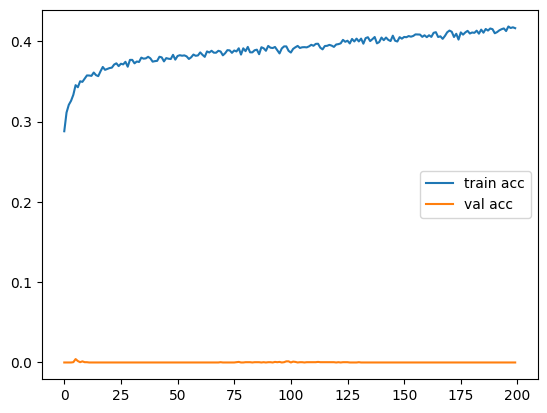

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [17]:
# --- Evaluate ---
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Accuracy: {test_acc:.2f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3615 - loss: 1.3524  
Test Accuracy: 0.24


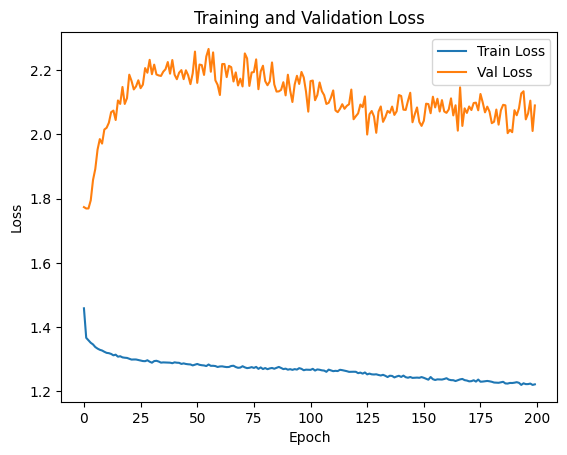

In [18]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


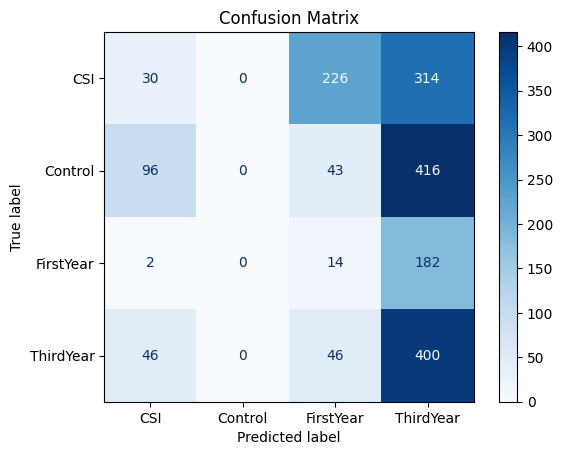

In [19]:
# --- Predict on test set ---
y_pred_probs = model.predict(X_test_seq)                     # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)                 # Convert to class indices
y_true = np.argmax(y_test_seq, axis=1)                       # Convert one-hot to class indices

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [20]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

         CSI       0.17      0.05      0.08       570
     Control       0.00      0.00      0.00       555
   FirstYear       0.04      0.07      0.05       198
   ThirdYear       0.30      0.81      0.44       492

    accuracy                           0.24      1815
   macro avg       0.13      0.23      0.14      1815
weighted avg       0.14      0.24      0.15      1815



/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [21]:
import shap

timesteps = X_train_seq.shape[1]
feature_size = X_train_seq.shape[2]

# Flatten over time for KernelExplainer input (required to make it 2D)
background = X_train_seq[:100].mean(axis=1)  # shape: (100, features)

# Define prediction function that reshapes 2D input back to 3D for the LSTM
def predict_fn(x):
    x_reshaped = x.reshape((x.shape[0], 1, feature_size))  # reshape to (batch, 1, features)
    return model.predict(x_reshaped)

explainer = shap.KernelExplainer(predict_fn, background)

# Flatten test samples too
X_test_flat = X_test_seq[:10].mean(axis=1)  # shape: (10, features)

# Explain predictions
shap_values = explainer.shap_values(X_test_flat)

/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


  0%|                                                    | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


 10%|████▍                                       | 1/10 [00:00<00:05,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


 20%|████████▊                                   | 2/10 [00:01<00:04,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


 30%|█████████████▏                              | 3/10 [00:01<00:03,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


 40%|█████████████████▌                          | 4/10 [00:02<00:03,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


 50%|██████████████████████                      | 5/10 [00:02<00:02,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


 60%|██████████████████████████▍                 | 6/10 [00:03<00:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


 70%|██████████████████████████████▊             | 7/10 [00:03<00:01,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


 80%|███████████████████████████████████▏        | 8/10 [00:04<00:01,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step


 90%|███████████████████████████████████████▌    | 9/10 [00:04<00:00,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.86it/s]


In [22]:
# Assume: shap_values has shape (samples, features, classes)
n_classes = shap_values.shape[2]
feature_names = features  # or manually define if needed

for class_idx in range(n_classes):
    print(f"\nTop features for class {label_encoder.classes_[class_idx]}")
    
    # Take absolute SHAP values for the given class and average over samples
    class_shap = np.abs(shap_values[:, :, class_idx]).mean(axis=0)  # shape: (features,)
    
    top_features = pd.Series(class_shap, index=feature_names).sort_values(ascending=False)
    print(top_features)


Top features for class CSI
Scene     0.004021
Image     0.001495
Start     0.000592
End       0.000494
Y         0.000428
ROI       0.000132
FixDur    0.000083
X         0.000060
dtype: float64

Top features for class Control
Image     0.000140
End       0.000075
Start     0.000072
Scene     0.000042
X         0.000015
FixDur    0.000011
Y         0.000006
ROI       0.000005
dtype: float64

Top features for class FirstYear
Scene     0.002930
Image     0.001189
Start     0.000442
End       0.000378
Y         0.000311
ROI       0.000102
FixDur    0.000063
X         0.000051
dtype: float64

Top features for class ThirdYear
Scene     0.001121
Image     0.000444
Start     0.000222
End       0.000193
Y         0.000118
ROI       0.000029
X         0.000026
FixDur    0.000022
dtype: float64
